References:

1. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
2. https://pywavelets.readthedocs.io/en/latest/

In [1]:
import os
import sys
import torch
import argparse
import torchvision
import numpy as np
import torch.nn as nn
import scipy.io as sio
import cv2
import pywt
import pywt.data
import matplotlib.image as image

from PIL import Image
from tqdm import tqdm
from datetime import datetime
from collections import defaultdict
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from os.path import join, isdir, abspath, dirname
import matplotlib.pyplot as plt
# Customized import.
from networks import HED
from datasets import BsdsDataset
from utils import Logger, AverageMeter, \
    load_checkpoint, save_checkpoint, load_vgg16_caffe, load_pretrained_caffe


# # Parse arguments.
# parser = argparse.ArgumentParser(description='HED training.')
# # 1. Actions.
# parser.add_argument('--test',             default=False,             help='Only test the model.', action='store_true')
# # 2. Counts.
# parser.add_argument('--train_batch_size', default=1,    type=int,   metavar='N', help='Training batch size.')
# parser.add_argument('--test_batch_size',  default=1,    type=int,   metavar='N', help='Test batch size.')
# parser.add_argument('--train_iter_size',  default=10,   type=int,   metavar='N', help='Training iteration size.')
# parser.add_argument('--max_epoch',        default=40,   type=int,   metavar='N', help='Total epochs.')
# parser.add_argument('--print_freq',       default=500,  type=int,   metavar='N', help='Print frequency.')
# # 3. Optimizer settings.
# parser.add_argument('--lr',               default=1e-6, type=float, metavar='F', help='Initial learning rate.')
# parser.add_argument('--lr_stepsize',      default=1e4,  type=int,   metavar='N', help='Learning rate step size.')
# # Note: Step size is based on number of iterations, not number of batches.
# #   https://github.com/s9xie/hed/blob/94fb22f10cbfec8d84fbc0642b224022014b6bd6/src/caffe/solver.cpp#L498
# parser.add_argument('--lr_gamma',         default=0.1,  type=float, metavar='F', help='Learning rate decay (gamma).')
# parser.add_argument('--momentum',         default=0.9,  type=float, metavar='F', help='Momentum.')
# parser.add_argument('--weight_decay',     default=2e-4, type=float, metavar='F', help='Weight decay.')
# # 4. Files and folders.
# parser.add_argument('--vgg16_caffe',      default='',                help='Resume VGG-16 Caffe parameters.')
# parser.add_argument('--checkpoint',       default='',                help='Resume the checkpoint.')
# parser.add_argument('--caffe_model',      default='',                help='Resume HED Caffe model.')
# parser.add_argument('--output',           default='./output',        help='Output folder.')
# parser.add_argument('--dataset',          default='./data/HED-BSDS', help='HED-BSDS dataset folder.')
# # 5. Others.
# parser.add_argument('--cpu',              default=False,             help='Enable CPU mode.', action='store_true')
# args = parser.parse_args()

# Set device.
device = torch.device('cuda')


In [2]:
def wav_trans_grayscale(images):
    images = torchvision.utils.make_grid(images)
    npimg = images.numpy()
    img_np_right_dim = np.transpose(npimg, (1, 2, 0))
    img_np_right_dim = cv2.cvtColor(img_np_right_dim, cv2.COLOR_BGR2GRAY)
    coeffs2 = pywt.dwt2(img_np_right_dim, 'haar')
    LL, (LH, HL, HH) = coeffs2
    return([LL, LH, HL, HH])

def WT_grayscale_path_input(path):  
    """Takes as input path string"""
    orig_image = plt.imread(path)
    if(len(orig_image.shape)==3):
        gray_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = orig_image
    coeffs2 = pywt.dwt2(gray_image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    return [LL, LH, HL, HH]

def im_save_path_modifier(input_path, mode):
    """
    parameter: input_path is the path of the original image
    parameter: mode is one of LL, LH, HL, HH
    """
    dir_path = input_path[:16] + f'{mode}/' + input_path[16:input_path.rfind('/')]
    image_path = input_path[:16] + f'{mode}/' + input_path[16:]
    return(dir_path, image_path)

def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
current_dir = abspath(dirname(__file__))

NameError: name '__file__' is not defined

In [3]:
################################################
# II. Datasets.
################################################
# Datasets and dataloaders.

train_dataset_LL = BsdsDataset(dataset_dir='./data/HED-BSDS/LL', split='train')

train_dataset_LH = BsdsDataset(dataset_dir='./data/HED-BSDS/LH', split='train')

train_dataset_HL = BsdsDataset(dataset_dir='./data/HED-BSDS/HL', split='train')

train_dataset_HH = BsdsDataset(dataset_dir='./data/HED-BSDS/HH', split='train')

train_loader_LL  = DataLoader(train_dataset_LL, batch_size=1,
                           num_workers=4, drop_last=True, shuffle=False)

train_loader_LH  = DataLoader(train_dataset_LH, batch_size=1,
                           num_workers=4, drop_last=True, shuffle=False)

train_loader_HL  = DataLoader(train_dataset_HL, batch_size=1,
                           num_workers=4, drop_last=True, shuffle=False)

train_loader_HH  = DataLoader(train_dataset_HH, batch_size=1,
                           num_workers=4, drop_last=True, shuffle=False)


# test_dataset  = BsdsDataset(dataset_dir='./data/HED-BSDS', split='test')

# test_loader   = DataLoader(test_dataset,  batch_size=1,
#                            num_workers=4, drop_last=False, shuffle=False)



In [4]:
dataiter_LL = iter(train_loader_LL)
dataiter_LH = iter(train_loader_LH)
dataiter_HL = iter(train_loader_HL)
dataiter_HH = iter(train_loader_HH)

In [5]:
# step 1: import 4 images from 4 dataloaders.

images_LL, labels1 = dataiter_LL.next()
images_LH, labels2 = dataiter_LH.next()
images_HL, labels3 = dataiter_HL.next()
images_HH, labels4 = dataiter_HH.next()


In [6]:
# verify that the images are the same
torch.equal(labels3, labels4)

True

In [7]:
net = nn.DataParallel(HED(device))
net.to(device);

In [8]:
# Initialize the weights for HED model.
def weights_init(m):
    """ Weight initialization function. """
    if isinstance(m, nn.Conv2d):
        # Initialize: m.weight.
        if m.weight.data.shape == torch.Size([1, 5, 1, 1]):
            # Constant initialization for fusion layer in HED network.
            torch.nn.init.constant_(m.weight, 0.2)
        else:
            # Zero initialization following official repository.
            # Reference: hed/docs/tutorial/layers.md
            m.weight.data.zero_()
        # Initialize: m.bias.
        if m.bias is not None:
            # Zero initialization.
            m.bias.data.zero_()

In [9]:
net.apply(weights_init);


In [10]:
net_parameters_id = defaultdict(list)

In [11]:
# Optimizer settings.
net_parameters_id = defaultdict(list)
for name, param in net.named_parameters():
    if name in ['module.conv1_1.weight', 'module.conv1_2.weight',
                'module.conv2_1.weight', 'module.conv2_2.weight',
                'module.conv3_1.weight', 'module.conv3_2.weight', 'module.conv3_3.weight',
                'module.conv4_1.weight', 'module.conv4_2.weight', 'module.conv4_3.weight']:
        print('{:26} lr:    1 decay:1'.format(name)); net_parameters_id['conv1-4.weight'].append(param)
    elif name in ['module.conv1_1.bias', 'module.conv1_2.bias',
                  'module.conv2_1.bias', 'module.conv2_2.bias',
                  'module.conv3_1.bias', 'module.conv3_2.bias', 'module.conv3_3.bias',
                  'module.conv4_1.bias', 'module.conv4_2.bias', 'module.conv4_3.bias']:
        print('{:26} lr:    2 decay:0'.format(name)); net_parameters_id['conv1-4.bias'].append(param)
    elif name in ['module.conv5_1.weight', 'module.conv5_2.weight', 'module.conv5_3.weight']:
        print('{:26} lr:  100 decay:1'.format(name)); net_parameters_id['conv5.weight'].append(param)
    elif name in ['module.conv5_1.bias', 'module.conv5_2.bias', 'module.conv5_3.bias'] :
        print('{:26} lr:  200 decay:0'.format(name)); net_parameters_id['conv5.bias'].append(param)
    elif name in ['module.score_dsn1.weight', 'module.score_dsn2.weight',
                  'module.score_dsn3.weight', 'module.score_dsn4.weight', 'module.score_dsn5.weight']:
        print('{:26} lr: 0.01 decay:1'.format(name)); net_parameters_id['score_dsn_1-5.weight'].append(param)
    elif name in ['module.score_dsn1.bias', 'module.score_dsn2.bias',
                  'module.score_dsn3.bias', 'module.score_dsn4.bias', 'module.score_dsn5.bias']:
        print('{:26} lr: 0.02 decay:0'.format(name)); net_parameters_id['score_dsn_1-5.bias'].append(param)
    elif name in ['module.score_final.weight']:
        print('{:26} lr:0.001 decay:1'.format(name)); net_parameters_id['score_final.weight'].append(param)
    elif name in ['module.score_final.bias']:
        print('{:26} lr:0.002 decay:0'.format(name)); net_parameters_id['score_final.bias'].append(param)


module.conv1_1.weight      lr:    1 decay:1
module.conv1_1.bias        lr:    2 decay:0
module.conv1_2.weight      lr:    1 decay:1
module.conv1_2.bias        lr:    2 decay:0
module.conv2_1.weight      lr:    1 decay:1
module.conv2_1.bias        lr:    2 decay:0
module.conv2_2.weight      lr:    1 decay:1
module.conv2_2.bias        lr:    2 decay:0
module.conv3_1.weight      lr:    1 decay:1
module.conv3_1.bias        lr:    2 decay:0
module.conv3_2.weight      lr:    1 decay:1
module.conv3_2.bias        lr:    2 decay:0
module.conv3_3.weight      lr:    1 decay:1
module.conv3_3.bias        lr:    2 decay:0
module.conv4_1.weight      lr:    1 decay:1
module.conv4_1.bias        lr:    2 decay:0
module.conv4_2.weight      lr:    1 decay:1
module.conv4_2.bias        lr:    2 decay:0
module.conv4_3.weight      lr:    1 decay:1
module.conv4_3.bias        lr:    2 decay:0
module.conv5_1.weight      lr:  100 decay:1
module.conv5_1.bias        lr:  200 decay:0
module.conv5_2.weight      lr:  

In [12]:
lr = 1e-6
momentum = 0.9
weight_decay = 2e-4
lr_stepsize = 1e4
lr_gamma = 0.1

In [13]:
# Create optimizer.
opt = torch.optim.SGD([
    {'params': net_parameters_id['conv1-4.weight']      , 'lr': lr*1    , 'weight_decay': weight_decay},
    {'params': net_parameters_id['conv1-4.bias']        , 'lr': lr*2    , 'weight_decay': 0.},
    {'params': net_parameters_id['conv5.weight']        , 'lr': lr*100  , 'weight_decay': weight_decay},
    {'params': net_parameters_id['conv5.bias']          , 'lr': lr*200  , 'weight_decay': 0.},
    {'params': net_parameters_id['score_dsn_1-5.weight'], 'lr': lr*0.01 , 'weight_decay': weight_decay},
    {'params': net_parameters_id['score_dsn_1-5.bias']  , 'lr': lr*0.02 , 'weight_decay': 0.},
    {'params': net_parameters_id['score_final.weight']  , 'lr': lr*0.001, 'weight_decay': weight_decay},
    {'params': net_parameters_id['score_final.bias']    , 'lr': lr*0.002, 'weight_decay': 0.},
], lr=lr, momentum=momentum, weight_decay=weight_decay)
# Note: In train_val.prototxt and deploy.prototxt, the learning rates of score_final.weight/bias are different.

# Learning rate scheduler.
lr_schd = lr_scheduler.StepLR(opt, step_size=lr_stepsize, gamma=lr_gamma)


In [14]:
################################################
# IV. Pre-trained parameters.
################################################
# Load parameters from pre-trained VGG-16 Caffe model.
load_vgg16_caffe(net, './data/5stage-vgg.py36pickle');

# # Resume the checkpoint.
# if args.checkpoint:
#     load_checkpoint(net, opt, args.checkpoint)  # Omit the returned values.

# # Resume the HED Caffe model.
# if args.caffe_model:
#     load_pretrained_caffe(net, args.caffe_model)


=> Start loading parameters...
=> Loaded module.conv1_1.weight.
=> Loaded module.conv1_1.bias.
=> Loaded module.conv1_2.weight.
=> Loaded module.conv1_2.bias.
=> Loaded module.conv2_1.weight.
=> Loaded module.conv2_1.bias.
=> Loaded module.conv2_2.weight.
=> Loaded module.conv2_2.bias.
=> Loaded module.conv3_1.weight.
=> Loaded module.conv3_1.bias.
=> Loaded module.conv3_2.weight.
=> Loaded module.conv3_2.bias.
=> Loaded module.conv3_3.weight.
=> Loaded module.conv3_3.bias.
=> Loaded module.conv4_1.weight.
=> Loaded module.conv4_1.bias.
=> Loaded module.conv4_2.weight.
=> Loaded module.conv4_2.bias.
=> Loaded module.conv4_3.weight.
=> Loaded module.conv4_3.bias.
=> Loaded module.conv5_1.weight.
=> Loaded module.conv5_1.bias.
=> Loaded module.conv5_2.weight.
=> Loaded module.conv5_2.bias.
=> Loaded module.conv5_3.weight.
=> Loaded module.conv5_3.bias.
=> Finish loading parameters.


In [15]:
net.train()
opt.zero_grad()
batch_loss_meter = AverageMeter()
lr_schd.step()
images_LL, labels1 = images_LL.to(device), labels1.to(device)


/datasets/home/24/524/cpatil/.local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [46]:
preds_list_LL = net(images_LL)
preds_list_LH = net(images_LH)
preds_list_HL = net(images_HL)
preds_list_HH = net(images_HH)

In [47]:
preds_list_HH[0].shape

torch.Size([1, 1, 192, 272])

In [49]:
list_reconstruct = []
for i in range(6):
    LL = preds_list_LL[i].cpu().detach().numpy().reshape(192, 272)
    LH = preds_list_LH[i].cpu().detach().numpy().reshape(192, 272)
    HL = preds_list_HL[i].cpu().detach().numpy().reshape(192, 272)
    HH = preds_list_HH[i].cpu().detach().numpy().reshape(192, 272)
    full_image = pywt.idwt2((LL, (LH, HL, HH)), 'haar')
    list_reconstruct.append(full_image)

In [51]:
full_image.shape # assume this is the correct shape

(384, 544)

In [53]:
# calculate loss

def weighted_cross_entropy_loss(preds, edges):
    """ Calculate sum of weighted cross entropy loss. """
    # Reference:
    #   hed/src/caffe/layers/sigmoid_cross_entropy_loss_layer.cpp
    #   https://github.com/s9xie/hed/issues/7
    mask = (edges > 0.5).float()
    b, c, h, w = mask.shape
    num_pos = torch.sum(mask, dim=[1, 2, 3]).float()  # Shape: [b,].
    num_neg = c * h * w - num_pos                     # Shape: [b,].
    weight = torch.zeros_like(mask)
    weight[edges > 0.5]  = num_neg / (num_pos + num_neg)
    weight[edges <= 0.5] = num_pos / (num_pos + num_neg)
    # Calculate loss.
    losses = torch.nn.functional.binary_cross_entropy(preds.float(), edges.float(), weight=weight, reduction='none')
    loss   = torch.sum(losses) / b
    return loss

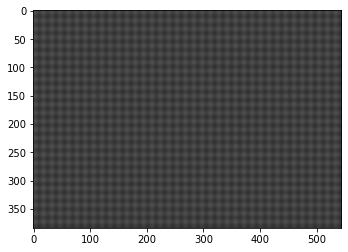

In [50]:
plt.imshow(list_reconstruct[3], cmap = 'gray')

In [5]:
train_dataset.__len__()

28800

In [119]:
images, labels, path, label_path = dataiter.next()

wav_trans_imlist = WT_grayscale_path_input(path[0])
wav_trans_imlist_names  = ['LL', 'LH', 'HL', 'HH']


for i in range(len(wav_trans_imlist)):
    
    # saving image
    
    dir_path, image_path = im_save_path_modifier(path[0], str(wav_trans_imlist_names[i]))
    os.makedirs(dir_path)
    plt.imsave(image_path, wav_trans_imlist[i], cmap = 'gray')
    
    # saving label
    # retrieve label image
    im_label = plt.imread(label_path[0])
    label_dir_path_new, label_path_new = im_save_path_modifier(label_path[0], str(wav_trans_imlist_names[i]))
    os.makedirs(label_dir_path_new)
    plt.imsave(label_path_new, im_label, cmap = 'gray')


StopIteration: 

In [106]:
sad_images = []
sad_labels = []

In [1]:
for j, data in tqdm(enumerate(train_loader, 0)):
    
    images, path = data
    
    print(path[0])

#     wav_trans_imlist = WT_grayscale_path_input(path[0])
#     wav_trans_imlist_names  = ['LL', 'LH', 'HL', 'HH']


#     for i in range(len(wav_trans_imlist)):

#         # saving image

#         dir_path, image_path = im_save_path_modifier(path[0], str(wav_trans_imlist_names[i]))
#         os.makedirs(dir_path, exist_ok=True)
#         plt.imsave(image_path, wav_trans_imlist[i], cmap = 'gray')

#         # saving label
#         # retrieve label image
#         im_label = plt.imread(label_path[0])
#         label_dir_path_new, label_path_new = im_save_path_modifier(label_path[0], str(wav_trans_imlist_names[i]))
#         os.makedirs(label_dir_path_new, exist_ok=True)
#         plt.imsave(label_path_new, im_label, cmap = 'gray')
        
#     if(j%1000==0):
#         print(j)

NameError: name 'tqdm' is not defined

In [109]:
len(sad_labels)

15684

Idea: Instead of taking image from the dataloader, we take the image path from it and get the image ourselves from the path. So we don't have to deal with torch tensors.

We should convert to numpy before saving images and labels.

In [ ]:
imshow(torchvision.utils.make_grid(images))

Preprocessing:  
Option 1:

1. Take wavelet transform of every channel
2. Stack up RGB channels after performing wavelet transform
3. Feed this to network.

Option 2:

1. Take grayscale of the input image
2. Pass this to network.  
Note: For option 2, we will have to change the first layer of the network to suit our changed dimensions of input.

NameError: name 'LL' is not defined

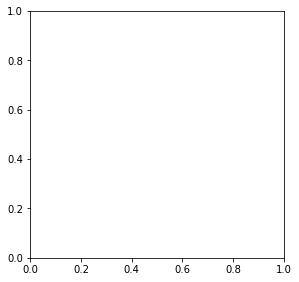

In [18]:
fig = plt.figure(figsize = [10,10])
ax1 = fig.add_subplot(221)
ax1.imshow(LL, cmap = 'gray')
ax1.set_title('LL')
ax2 = fig.add_subplot(222)
ax2.imshow(LH, cmap = 'gray')
ax2.set_title('LH')
ax3 = fig.add_subplot(223)
ax3.imshow(HL, cmap = 'gray')
ax3.set_title('HL')
ax4 = fig.add_subplot(224)
ax4.imshow(HH, cmap = 'gray')
ax4.set_title('HH')

1. Write a function that does this - Done!
2. Create 4 datasets
3. Train 4 networks

Step 2:

We need to:

1. Load image from path normal/p1  
2. Preprocess image
3. Save it in LL/p1, LH/p1, HL/p1, and HH/p1

1. Use os.mkdir for one image - Done!
2. Do it for every mode. - Done!
3. Do it for every image. - Pending!

#### Tasks for 11/28
1. solve np shape error
2. do it for every image

We decided not to do the wavelet transform for labels, because what's the point.

#### Dec 7 Meeting

1. calculate loss for 1 image  
    a. outputs of all neural networks  
    b. Perform IDWT and combine them into final image  
    c. Use weighted_cross_entropy_loss to calculate loss.  

2. Then worry about backpropagation